# training-F.ipynb
1. This code is intended for training three models with *wavelet features* data from MIT-BIH arrhythmia database and additional ECG data with a format of .bin
2. There are 5 classes/labels: N, S, V, F, and Q

## **LIBRARY IMPORTS**

In [1]:
# Import Libraries
import cudf
import os
import joblib
import pywt
import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import wfdb  # For reading MIT-BIH data
import keras_tuner as kt
import seaborn as sns
import tensorflow as tf
import neurokit2 as nk

# Scikit-learn and Imbalanced-learn imports
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    precision_recall_curve,
    auc,
    f1_score,
    precision_score,
    recall_score,
    accuracy_score
)
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.combine import SMOTEENN, SMOTETomek
from imblearn.pipeline import Pipeline as ImbPipeline
from scipy.stats import entropy
from collections import Counter
from scipy.signal import find_peaks, resample, butter, filtfilt, iirnotch, spectrogram
from sklearn.utils import class_weight
from glob import glob

# Model imports
from sklearn.svm import SVC
from imblearn.ensemble import BalancedRandomForestClassifier
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Conv1D, BatchNormalization, Activation, MaxPooling1D, Dropout, Add, GlobalAveragePooling1D, Dense, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from cuml.ensemble import RandomForestClassifier
from scikeras.wrappers import KerasClassifier
from sklearn.utils.class_weight import compute_class_weight

# Additional setups
# Checking cUML
print(cudf.Series([1, 2, 3]))

# Setting TensorFlow flags
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# Checking GPU
gpu_devices = tf.config.list_physical_devices('GPU')
if gpu_devices:
    print(f"TensorFlow has detected {len(gpu_devices)} GPU(s):")
    for device in gpu_devices:
        print(f"- {device}")
else:
    print("TensorFlow did not detect any GPUs. Training will run on the CPU.")


2025-08-27 22:24:37.636807: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-27 22:24:38.269881: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1756308278.462128  100480 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1756308278.509588  100480 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1756308278.949953  100480 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

0    1
1    2
2    3
dtype: int64
TensorFlow has detected 1 GPU(s):
- PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


## **DATA PREPARATION**

### DATA PREPARATION FUNCTIONS
1. Database: MIT-BIH Arrhythmia Database & additional ECG data with a format of .bin files and from heartbeat simulator
2. Preparation: *Windowed Features* of RR Intervals

In [2]:
# Labels
label_map = { 'N': 0, 'L': 0, 'R': 0, 'e': 0, 'j': 0,  # Normal Beats (N)
              'V': 1, 'E': 1,                          # Ventricular Ectopic (VEB)
              'S': 2, 'A': 2, 'a': 2, 'J': 2,          # Supraventricular Ectopic (SVEB)
              'F': 3,                                  # Fusion Beat (F)
              'P': 4, 'f': 4, 'Q': 4, '?': 4, "U": 4}          # Unknown Beat (Q)

# Membagi data menjadi sumbu X dan sumbu Y
def create_windowed_features(rr_intervals, labels, window_size):
    """RR intervals features extraction"""
    X, y = [], []
    for i in range(len(rr_intervals) - window_size):
        segment = rr_intervals[i:i+window_size]
        # Label sesuai dengan detak di akhir jendela
        label = labels[i + window_size - 1]
        X.append(segment)
        y.append(label)
    return np.array(X), np.array(y)

In [3]:
# Fungsi-fungsi baca data MIT-BIH
# Membaca data MIT-BIH
def load_mitbih_data(record_names, db_path):
    """
    Memuat sinyal EKG dan anotasi dari data MIT-BIH.
    Args:
        record_name (str): Nama record (misal, '100').
        db_path (str): Direktori database di PhysioNet (misal, 'mit-bih').

    Return:
      Mengembalikan data RAW ECG dari masing-masing record dalam bentuk array numpy (signal), label kelas dalam bentuk array numpy (annotation),
      dan frekuensi sampling (fs).
        tuple: (signal, annotation, fs)

    """
    signals, annotations = [], []
    for record in record_names:
        record_path = f'{db_path}/{record}'
        # Baca sinyal dari kanal pertama (umumnya MLII)
        signal = wfdb.rdrecord(record_path, channels=[0]).p_signal.flatten() #Selain .dat
        annotation = wfdb.rdann(record_path, 'atr') #.dat
        signals.append(signal)
        annotations.append(annotation)
    return signals, annotations

# Membaca annotations dan labels dari masing-masing data yang telah di-load
def extract_rr_intervals_and_labels(annotations):
    """Mengekstrak interval RR dan label detak jantung yang sesuai."""
    all_rr, labels = [], []
    for ann in annotations:
        r_peaks = ann.sample
        beat_symbols = ann.symbol
        # Butuh setidaknya dua R-peak untuk menghitung interval
        for i in range(1, len(r_peaks)):
            symbol = beat_symbols[i]
            if symbol in label_map:
                rr_interval = (r_peaks[i] - r_peaks[i-1]) / ann.fs  # Gunakan frekuensi sampling spesifik rekaman
                all_rr.append(rr_interval)
                labels.append(label_map[symbol])
    return np.array(all_rr), np.array(labels)

In [4]:
# Fungsi-fungsi baca data dari .bin
# Membaca data dari .bin
def load_ecg_from_bin(file_path, dtype=np.int16):
    """
    Memuat sinyal EKG mentah dari sebuah file biner.

    Args:
        file_path (str): Path ke file .bin.
        dtype (numpy.dtype): Tipe data dari sinyal dalam file biner.

    Return:
        numpy.ndarray: Sinyal EKG sebagai array numpy.
    """
    try:
        # Membaca file biner dan mengubahnya menjadi array numpy
        signal = np.fromfile(file_path, dtype=dtype)
        print(f"Berhasil membaca {len(signal)} sampel dari {file_path}")
        return signal
    except IOError as e:
        print(f"Error saat membaca file: {e}")
        return None

def detect_r_peaks(signal, fs):
    """
    Mendeteksi R-peaks dari sinyal ECG.

    Args:
        signal (numpy.ndarray): Sinyal EKG mentah.
        fs (int): Frekuensi sampling sinyal.

    Return:
        numpy.ndarray: Array berisi lokasi (indeks) dari R-peak yang terdeteksi.
    """
    print("\n--- Langkah 1: Mendeteksi R-Peak ---")
    # Parameter 'height' dan 'distance' bisa disesuaikan dengan sinyal Anda
    height_threshold = np.max(signal) * 0.5
    distance_threshold = fs * 0.4  # Jarak minimal antar detak

    r_peaks, _ = find_peaks(signal, height=height_threshold, distance=distance_threshold)

    print(f"Terdeteksi {len(r_peaks)} R-peaks.")
    return r_peaks

def extract_rr_and_apply_label_ecg_bin(r_peaks, fs, record_label):
    """
    Menghitung interval RR dari satu record dan memberikan satu label yang sama
    untuk semua interval tersebut.

    Args:
        r_peaks (numpy.ndarray): Array berisi lokasi R-peak (dalam indeks sampel) dari satu record.
        fs (int): Frekuensi sampling sinyal.
        record_label (any): Label tunggal (misalnya, string atau integer) yang akan
                            diterapkan untuk seluruh record ini.

    Return:
        tuple: Tuple berisi (rr_intervals, labels).
               - rr_intervals (numpy.ndarray): Array berisi interval RR dalam detik.
               - labels (numpy.ndarray): Array berisi label yang sama untuk setiap interval RR.
    """
    print(f"\n--- Langkah 2: Ekstraksi RR dan Pelabelan untuk Record ---")

    # Memastikan ada cukup R-peak untuk menghitung setidaknya satu interval
    if len(r_peaks) < 2:
        print("Peringatan: Jumlah R-peak tidak cukup untuk menghitung interval RR.")
        return np.array([]), np.array([])

    # Menghitung semua interval RR dalam detik
    rr_intervals = np.diff(r_peaks) / fs

    # Membuat array label di mana setiap elemen adalah 'record_label'
    # Ukuran array label ini sama dengan jumlah interval RR yang dihitung
    num_rr_intervals = len(rr_intervals)
    labels = np.full(shape=num_rr_intervals, fill_value=record_label)

    return rr_intervals, labels

### DATA PREPARATION EXECUTION
1. Reading all ECG datasets
2. Divide all datasets into training dataset and testing dataset
3. Standard scaling and combining datasets
4. Splitting training dataset into training split and validation split then applying SMOTE algorithm into the training split
5. Preparing all the datasets for each machine learning model
The feature extraction of this data is transforming the data into wavelet data. Beforehand, the data was transformed into RR-intervals only data, but the data provided is limited to its RR-intervals and it didn't represent the heartbeat morphology of the data. Then, it was transformed into raw ECG data which is better than before, but the data was costly and thus needed further transformation. Lastly, it is transformed into wavelet data

In [8]:
if __name__ == '__main__':
    # --- 0. INITIAL PARAMETERS FOR .BIN AND MIT-BIH DATA PREPARATION ---
    mitbih_dir = '../data/raw/MIT-BIH/mit-bih-arrhythmia-database-1.0.0/mit-bih-arrhythmia-database-1.0.0/'
    window_size = 10
    
    # DS1 is used for training
    ds1 = ['101', '106', '108', '109', '112', '114', '115', '116', '118', '119',
           '122', '124', '201', '203', '205', '207', '208', '209', '215', '220',
           '223', '230'] 
    # DS2 is used for evaluation
    ds2 = ['100', '103', '105', '111', '113', '117', '121', '123', '200', '202',
           '210', '212', '213', '214', '219', '221', '222', '228', '231', '232',
           '233', '234'] 
           
    FS_CUSTOM = 500  # IMPORTANT: Adjust to the sampling frequency of your .bin data
    custom_file_paths = {
        'Arrhythmia': '../data/raw/Arrhythmia/ECG_WAVE.bin',
        'Normal': '../data/raw/Normal/ecg_normal.bin'
    }
    custom_file_labels = {'Arrhythmia': 2, 'Normal': 0}

    print("="*60)
    print("🚀 STARTING DATASET PREPARATION PROCESS 🚀")
    print("="*60)

    # --- 1. PROCESS TRAINING DATA (ds1) ---
    print("\n--- [Step 1/5] Processing Training Data (ds1) ---")
    signals_train, annotations_train = load_mitbih_data(ds1, mitbih_dir)
    rr_train, labels_train = extract_rr_intervals_and_labels(annotations_train)
    X_train, y_train = create_windowed_features(rr_train, labels_train, window_size)
    print(f"Raw training data ready: X_train={X_train.shape}, y_train={y_train.shape}")

    # --- 2. PROCESS TESTING DATA (Combination of ds2 and .bin) ---
    print("\n--- [Step 2/5] Processing Testing Data ---")

    # Part A: Process testing data from MIT-BIH (ds2)
    print("\nProcessing testing part 1 (ds2)...")
    signals_test_mitbih, annotations_test_mitbih = load_mitbih_data(ds2, mitbih_dir)
    rr_test_mitbih, labels_test_mitbih = extract_rr_intervals_and_labels(annotations_test_mitbih)
    X_test_mitbih, y_test_mitbih = create_windowed_features(rr_test_mitbih, labels_test_mitbih, window_size)
    print(f"MIT-BIH testing data ready: X_test_mitbih={X_test_mitbih.shape}, y_test_mitbih={y_test_mitbih.shape}")

    # Part B: Process testing data from .bin files
    print("\nProcessing testing part 2 (.bin)...")
    all_rr_custom = []
    all_labels_custom = []
    for category, path in custom_file_paths.items():
        signal_custom = load_ecg_from_bin(path)
        if signal_custom is not None:
            r_peaks_custom = detect_r_peaks(signal_custom, fs=FS_CUSTOM)
            rr_intervals_c, labels_c = extract_rr_and_apply_label_ecg_bin(
                r_peaks_custom, fs=FS_CUSTOM, record_label=custom_file_labels[category]
            )
            all_rr_custom.append(rr_intervals_c)
            all_labels_custom.append(labels_c)

    rr_test_custom = np.concatenate(all_rr_custom)
    labels_test_custom = np.concatenate(all_labels_custom)
    X_test_custom, y_test_custom = create_windowed_features(rr_test_custom, labels_test_custom, window_size)

    # --- 3. SCALING & COMBINING TESTING DATA ---
    print("\n--- [Step 3/5] Scaling and Finalizing Data ---")
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    print("Scaler trained on training data.")

    # Apply the scaler to all parts of the testing data
    X_test_mitbih_scaled = scaler.transform(X_test_mitbih)
    X_test_custom_scaled = scaler.transform(X_test_custom)
    print("Scaler applied to all testing data.")

    # Combine all scaled testing data
    X_test_final = np.concatenate((X_test_mitbih_scaled, X_test_custom_scaled), axis=0)
    y_test_final = np.concatenate((y_test_mitbih, y_test_custom), axis=0)
    print(f"Final testing data combined: X_test_final={X_test_final.shape}, y_test_final={y_test_final.shape}")

    # --- 4. TRAINING SET SPLIT & OVERSAMPLING (SMOTE) ---
    print("\n--- [Step 4/5] Finalizing Training Data (Split & SMOTE) ---")
    print("Creating validation set from training data (80/20)...")
    X_train_fold, X_val, y_train_fold, y_val = train_test_split(
        X_train_scaled, y_train, test_size=0.2, random_state=42, stratify=y_train
    )

    print("Applying SMOTE only to the training fold...")
    print("Training class distribution before SMOTE:", Counter(y_train_fold))
    smote = SMOTE(random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train_fold, y_train_fold)
    print("Training class distribution after SMOTE:", Counter(y_train_resampled))

    # --- 5. FINAL DATA PREPARATION FOR MODELS ---
    print("\n--- [Step 5/5] Preparing Final Datasets for Models ---")

    # Define output_dim based on the number of unique classes in the original training data
    output_dim = len(np.unique(y_train))

    # One-hot encode labels for Keras
    y_train_encoded = to_categorical(y_train_resampled, num_classes=output_dim)
    y_val_encoded = to_categorical(y_val, num_classes=output_dim)
    y_test_final_encoded = to_categorical(y_test_final, num_classes=output_dim)

    # 🧠 Data for MLP
    X_train_mlp, y_train_mlp = X_train_resampled, y_train_encoded
    X_val_mlp, y_val_mlp = X_val, y_val_encoded
    X_test_mlp, y_test_mlp = X_test_final, y_test_final_encoded

    # ⚡ Data for 1D-CNN
    X_train_cnn = X_train_mlp.reshape((X_train_mlp.shape[0], X_train_mlp.shape[1], 1))
    X_val_cnn = X_val_mlp.reshape((X_val_mlp.shape[0], X_val_mlp.shape[1], 1))
    X_test_cnn = X_test_mlp.reshape((X_test_mlp.shape[0], X_test_mlp.shape[1], 1))
    y_train_cnn, y_val_cnn, y_test_cnn = y_train_mlp, y_val_mlp, y_test_mlp

    # 📊 Data for RandomForest
    X_train_rf, y_train_rf = X_train_resampled, y_train_resampled
    X_val_rf, y_val_rf = X_val, y_val
    X_test_rf, y_test_rf = X_test_final, y_test_final

    # --- FINAL RESULTS ---
    print("\n" + "="*60)
    print("✅ DATA PREPARATION COMPLETE ✅")
    print("The following variables are ready for training and evaluation:")
    print("="*60)

    print("\n--- For MLP ---")
    print(f"  Training:   X_train_mlp: {X_train_mlp.shape}, y_train_mlp: {y_train_mlp.shape}")
    print(f"  Validation: X_val_mlp: {X_val_mlp.shape}, y_val_mlp: {y_val_mlp.shape}")
    print(f"  Testing:    X_test_mlp: {X_test_mlp.shape}, y_test_mlp: {y_test_mlp.shape}")

    print("\n--- For 1D-CNN ---")
    print(f"  Training:   X_train_cnn: {X_train_cnn.shape}, y_train_cnn: {y_train_cnn.shape}")
    print(f"  Validation: X_val_cnn: {X_val_cnn.shape}, y_val_cnn: {y_val_cnn.shape}")
    print(f"  Testing:    X_test_cnn: {X_test_cnn.shape}, y_test_cnn: {y_test_cnn.shape}")

    print("\n--- For RandomForest ---")
    print(f"  Training:   X_train_rf: {X_train_rf.shape}, y_train_rf: {y_train_rf.shape}")
    print(f"  Validation: X_val_rf: {X_val_rf.shape}, y_val_rf: {y_val_rf.shape}")
    print(f"  Testing:    X_test_rf: {X_test_rf.shape}, y_test_rf: {y_test_rf.shape}")

🚀 STARTING DATASET PREPARATION PROCESS 🚀

--- [Step 1/5] Processing Training Data (ds1) ---
Raw training data ready: X_train=(51011, 10), y_train=(51011,)

--- [Step 2/5] Processing Testing Data ---

Processing testing part 1 (ds2)...
MIT-BIH testing data ready: X_test_mitbih=(49702, 10), y_test_mitbih=(49702,)

Processing testing part 2 (.bin)...
Berhasil membaca 2380000 sampel dari ../data/raw/Arrhythmia/ECG_WAVE.bin

--- Langkah 1: Mendeteksi R-Peak ---
Terdeteksi 171 R-peaks.

--- Langkah 2: Ekstraksi RR dan Pelabelan untuk Record ---
Berhasil membaca 2135000 sampel dari ../data/raw/Normal/ecg_normal.bin

--- Langkah 1: Mendeteksi R-Peak ---
Terdeteksi 154 R-peaks.

--- Langkah 2: Ekstraksi RR dan Pelabelan untuk Record ---

--- [Step 3/5] Scaling and Finalizing Data ---
Scaler trained on training data.
Scaler applied to all testing data.
Final testing data combined: X_test_final=(50015, 10), y_test_final=(50015,)

--- [Step 4/5] Finalizing Training Data (Split & SMOTE) ---
Creatin

## **MACHINE LEARNING MODEL TRAINING & SAVING**

### MACHINE LEARNING MODEL FUNCTIONS
There are 3 models that will be trained:
1. MLP Model (TA242501010)
2. 1D-CNN
3. BalancedRandomForest

There is also an additional function in order to do automatic hyperparameter tuning, but the function is only made for the MLP model.

In [9]:
# Function to build the MLP model for automatic hyperparameter tuning
def build_model(hp):
    """Function that builds a Keras model and defines the hyperparameters to be tuned."""
    model = Sequential()

    # Tune the number of units in the first hidden layer
    hp_units_1 = hp.Int('units_1', min_value=32, max_value=256, step=32)
    model.add(Dense(units=hp_units_1, activation='relu', input_shape=(X_train.shape[1],)))

    # Tune the dropout rate
    hp_dropout_1 = hp.Float('dropout_1', min_value=0.1, max_value=0.5, step=0.1)
    model.add(Dropout(rate=hp_dropout_1))

    # Tune the number of units in the second hidden layer
    hp_units_2 = hp.Int('units_2', min_value=32, max_value=256, step=32)
    model.add(Dense(units=hp_units_2, activation='relu'))

    # Tune the dropout rate
    hp_dropout_2 = hp.Float('dropout_2', min_value=0.1, max_value=0.5, step=0.1)
    model.add(Dropout(hp_dropout_2))
    model.add(Dense(output_dim, activation='softmax'))

    # Tune the learning rate for the Adam optimizer
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    model.compile(
        optimizer=Adam(learning_rate=hp_learning_rate),
        loss='categorical_crossentropy',
        metrics=[
            'accuracy',
            tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.Recall(name='recall'),
            tf.keras.metrics.AUC(name='auc_roc'),
            tf.keras.metrics.AUC(name='auc_pr', curve='PR'),
            tf.keras.metrics.F1Score(average='weighted', name='f1_score')
        ]
    )
    return model

# Function to create the 1D-CNN model
def create_cnn_model(input_shape, output_dim):
    """Creates and compiles a Keras 1D-CNN model."""
    # Input shape for CNN must be 3D: (samples, steps, features)
    # Example: (10000, 187, 1)

    model = Sequential([
        Conv1D(filters=512, kernel_size=6, activation='relu', # Reduced filters
               input_shape=input_shape),
        Dropout(0.1),
        MaxPooling1D(pool_size=2),

        Conv1D(filters=512, kernel_size=3, activation='relu'), # Reduced filters
        Dropout(0.2),
        MaxPooling1D(pool_size=2),

        Flatten(), # Now flattens a much smaller tensor

        Dense(512, activation='relu'), # Reduced dense units
        Dropout(0.4),

        Dense(output_dim, activation='softmax')
    ])

    model.compile(
        optimizer=Adam(learning_rate=0.0001),
        loss='categorical_crossentropy',
        metrics=[
            'accuracy',
            tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.Recall(name='recall'),
            tf.keras.metrics.F1Score(average='weighted', name='f1_score'),
            tf.keras.metrics.SpecificityAtSensitivity(0.9, name='specificity')
        ]
    )
    return model

# Function to create the MLP model for cross-validation
def create_mlp_model(input_dim, output_dim):
    """Creates and compiles a Keras MLP model."""
    model = Sequential([
        # Hyperparameters tuning
        Dense(512, input_dim=input_dim, activation='relu'),
        Dropout(0.1),
        Dense(512, activation='relu'),
        Dropout(0.4),
        Dense(output_dim, activation='softmax') # Softmax for multi-class classification
    ])
    model.compile(
        optimizer=Adam(learning_rate=0.0001),
        loss='categorical_crossentropy', # Suitable for one-hot labels
        metrics=[
            'accuracy',
            # tf.keras.metrics.Precision(name='precision'),
            # tf.keras.metrics.Recall(name='recall'),
            tf.keras.metrics.F1Score(average='weighted', name='f1_score'),
            tf.keras.metrics.SpecificityAtSensitivity(0.9, name='specificity')
        ]
    )
    return model

def create_cnn_model_optimized(input_shape, output_dim, hp=None):
    """
    Creates and compiles an optimized 1D-CNN model.
    If 'hp' is provided, it builds a tunable model for KerasTuner.
    Otherwise, it builds a model with default hyperparameters.
    """
    # Define a default hyperparameter object if none is passed
    if hp is None:
        hp = kt.HyperParameters()
        # Set default values for when not tuning
        hp.values['conv4_filters'] = 100
        hp.values['dense_units'] = 256
        hp.values['learning_rate'] = 0.0001

    inputs = Input(shape=input_shape)
    x = Conv1D(filters=64, kernel_size=3, activation='relu', padding='valid', name='conv1d_1_freezed')(inputs)
    x = MaxPooling1D(pool_size=2, name='maxpool1d_1_freezed')(x)
    x = Conv1D(filters=64, kernel_size=3, activation='relu', padding='same', name='conv1d_2_freezed')(x)
    x = MaxPooling1D(pool_size=2, name='maxpool1d_2_freezed')(x)
    x = Conv1D(filters=4, kernel_size=3, activation='relu', padding='same', name='conv1d_3_freezed')(x)
    x = MaxPooling1D(pool_size=2, name='maxpool1d_3_freezed')(x)
    # ===============================================
    #           Trainable Layers
    # ===============================================
    x = Conv1D(filters=hp.values['conv4_filters'], kernel_size=3, activation='relu', padding='same', name='conv1d_4_trainable')(x)
    x = Flatten(name='flatten_layer')(x)
    x = Dense(units=hp.values['dense_units'], activation='relu', name='dense_1_trainable')(x)
    outputs = Dense(units=output_dim, activation='softmax', name='output_layer_trainable')(x)
    model = Model(inputs=inputs, outputs=outputs)
    
    model.compile(
        optimizer=Adam(learning_rate=hp.values['learning_rate']),
        loss='categorical_crossentropy',
        metrics=[
            'accuracy',
            tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.Recall(name='recall'),
            tf.keras.metrics.F1Score(average='weighted', name='f1_score'),
            tf.keras.metrics.SpecificityAtSensitivity(0.9, name='specificity')
        ]
    )
    return model

# def create_cnn_model_optimized(input_shape, output_dim, hp=None):
#     """
#     Creates and compiles an optimized 1D-CNN model.
#     If 'hp' is provided, it builds a tunable model for KerasTuner.
#     Otherwise, it builds a model with default hyperparameters.
#     """
#     # Define a default hyperparameter object if none is passed
#     if hp is None:
#         hp = kt.HyperParameters()
#         # Set default values for when not tuning
#         hp.values['initial_filters'] = 384
#         hp.values['res_block_1_filters'] = 384
#         hp.values['res_block_2_filters'] = 384
#         hp.values['kernel_size_initial'] = 7
#         hp.values['kernel_size_res'] = 5
#         hp.values['dropout_1'] = 0.1
#         hp.values['dropout_2'] = 0.3
#         hp.values['dense_units'] = 512
#         hp.values['dense_dropout'] = 0.5
#         hp.values['learning_rate'] = 0.0001

#     def residual_block(x, filters, kernel_size):
#         y = Conv1D(filters=filters, kernel_size=kernel_size, padding='same')(x)
#         y = BatchNormalization()(y)
#         y = Activation('relu')(y)
#         y = Conv1D(filters=filters, kernel_size=kernel_size, padding='same')(y)
#         y = BatchNormalization()(y)
#         shortcut = Conv1D(filters=filters, kernel_size=1, padding='same')(x) if x.shape[-1] != filters else x
#         res_output = Add()([shortcut, y])
#         return Activation('relu')(res_output)

#     inputs = Input(shape=input_shape)
#     x = Conv1D(filters=hp.values['initial_filters'], kernel_size=hp.values['kernel_size_initial'], padding='same')(inputs)
#     x = BatchNormalization()(x)
#     x = Activation('relu')(x)
#     x = MaxPooling1D(pool_size=2)(x)
#     x = residual_block(x, filters=hp.values['res_block_1_filters'], kernel_size=hp.values['kernel_size_res'])
#     x = MaxPooling1D(pool_size=2)(x)
#     x = Dropout(hp.values['dropout_1'])(x)
#     x = residual_block(x, filters=hp.values['res_block_2_filters'], kernel_size=hp.values['kernel_size_res'])
#     x = MaxPooling1D(pool_size=2)(x)
#     x = Dropout(hp.values['dropout_2'])(x)
#     x = GlobalAveragePooling1D()(x)
#     x = Dense(hp.values['dense_units'], activation='relu')(x)
#     x = Dropout(hp.values['dense_dropout'])(x)
#     outputs = Dense(output_dim, activation='softmax')(x)
    
#     model = Model(inputs=inputs, outputs=outputs)
    
#     model.compile(
#         optimizer=Adam(learning_rate=hp.values['learning_rate']),
#         loss='categorical_crossentropy',
#         metrics=[
#             # 'accuracy',
#             tf.keras.metrics.Precision(name='precision'),
#             tf.keras.metrics.Recall(name='recall'),
#             # Note: F1Score might require a different setup in some TF versions.
#             # If it causes issues, consider a custom callback to calculate it.
#             tf.keras.metrics.F1Score(average='weighted', name='f1_score'),
#             tf.keras.metrics.SpecificityAtSensitivity(0.9, name='specificity')
#         ]
#     )
#     return model

# Function to create the RandomForest model
def create_rf_model():
    """Creates an instance of the GPU-accelerated RandomForestClassifier model using cuML."""
    # Hyperparameters are similar to imblearn's
    return RandomForestClassifier(
        n_estimators=200, 
        max_depth=30, 
        random_state=42
    )

### MACHINE LEARNING MODEL TRAINING EXECUTION
1. Targeted metrics: Precision, Recall, F1-Score, and Specificity
2. There are 3 executions: multiple models training (1D-CNN, BalancedRandomForest, and MLP), MLP model specific training, and MLP model automatic hyperparameter tuning
3. After training, all models immediately saved and exported into a certain folder


==================== TRAINING MODEL: 1D-CNN ====================
Epoch 1/150


2025-08-27 22:32:19.056973: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_667', 180 bytes spill stores, 180 bytes spill loads

2025-08-27 22:32:19.268789: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_667', 316 bytes spill stores, 316 bytes spill loads

2025-08-27 22:32:19.461603: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_667', 424 bytes spill stores, 424 bytes spill loads

2025-08-27 22:32:19.615816: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_667', 120 bytes spill stores, 120 bytes spill loads

2025-08-27 22:32:19.632876: I extern

1827/1835 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5178 - f1_score: 0.5101 - loss: 1.1750 - precision: 0.7483 - recall: 0.2757 - specificity: 0.4837

2025-08-27 22:32:33.724882: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_667', 20 bytes spill stores, 20 bytes spill loads

2025-08-27 22:32:34.063461: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_674', 4 bytes spill stores, 4 bytes spill loads

2025-08-27 22:32:34.265520: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_667', 204 bytes spill stores, 204 bytes spill loads

2025-08-27 22:32:35.031138: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_974', 8 bytes spill stores, 8 bytes spill loads

2025-08-27 22:32:35.060389: I external/local_x

1835/1835 ━━━━━━━━━━━━━━━━━━━━ 28s 10ms/step - accuracy: 0.6671 - f1_score: 0.6692 - loss: 0.8893 - precision: 0.8384 - recall: 0.4936 - specificity: 0.6840 - val_accuracy: 0.7532 - val_f1_score: 0.8167 - val_loss: 0.7931 - val_precision: 0.8261 - val_recall: 0.7018 - val_specificity: 0.7982
Epoch 2/150
1835/1835 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8119 - f1_score: 0.8104 - loss: 0.5450 - precision: 0.8581 - recall: 0.7455 - specificity: 0.8945 - val_accuracy: 0.8041 - val_f1_score: 0.8538 - val_loss: 0.6165 - val_precision: 0.8526 - val_recall: 0.7695 - val_specificity: 0.8888
Epoch 3/150
1835/1835 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.8380 - f1_score: 0.8363 - loss: 0.4657 - precision: 0.8700 - recall: 0.8047 - specificity: 0.9236 - val_accuracy: 0.8308 - val_f1_score: 0.8710 - val_loss: 0.5430 - val_precision: 0.8676 - val_recall: 0.7972 - val_specificity: 0.9148
Epoch 4/150
1835/1835 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.8529 - f1_score: 0.8515 - loss: 

2025-08-27 22:53:21.032243: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_84', 204 bytes spill stores, 204 bytes spill loads

2025-08-27 22:53:21.180115: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_84', 20 bytes spill stores, 20 bytes spill loads



1532/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

2025-08-27 22:53:25.220112: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_100', 136 bytes spill stores, 136 bytes spill loads

2025-08-27 22:53:25.397196: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_107', 4 bytes spill stores, 4 bytes spill loads

2025-08-27 22:53:25.796914: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_100', 396 bytes spill stores, 396 bytes spill loads



1563/1563 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step

==================== TRAINING MODEL: RandomForest ====================
Evaluating model RandomForest...

==================== TRAINING MODEL: MLP ====================
Epoch 1/100
3669/3669 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7197 - f1_score: 0.7182 - loss: 0.8010 - specificity: 0.7592

2025-08-27 22:53:53.017909: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_109_0', 344 bytes spill stores, 344 bytes spill loads

2025-08-27 22:53:53.170276: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_109', 488 bytes spill stores, 488 bytes spill loads

2025-08-27 22:53:53.275961: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_109_0', 196 bytes spill stores, 492 bytes spill loads

2025-08-27 22:53:53.693600: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_116', 124 bytes spill stores, 124 bytes spill loads

2025-08-27 22:53:53.698181: I ex

3669/3669 ━━━━━━━━━━━━━━━━━━━━ 24s 5ms/step - accuracy: 0.7846 - f1_score: 0.7833 - loss: 0.6226 - specificity: 0.8602 - val_accuracy: 0.8173 - val_f1_score: 0.8656 - val_loss: 0.5792 - val_specificity: 0.8885
Epoch 2/100
3669/3669 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - accuracy: 0.8456 - f1_score: 0.8444 - loss: 0.4388 - specificity: 0.9344 - val_accuracy: 0.8401 - val_f1_score: 0.8794 - val_loss: 0.4878 - val_specificity: 0.9200
Epoch 3/100
3669/3669 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.8643 - f1_score: 0.8633 - loss: 0.3823 - specificity: 0.9517 - val_accuracy: 0.8297 - val_f1_score: 0.8723 - val_loss: 0.4843 - val_specificity: 0.9142
Epoch 4/100
3669/3669 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - accuracy: 0.8790 - f1_score: 0.8782 - loss: 0.3433 - specificity: 0.9625 - val_accuracy: 0.8319 - val_f1_score: 0.8751 - val_loss: 0.4865 - val_specificity: 0.9202
Epoch 5/100
3669/3669 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.8895 - f1_score: 0.8889 - loss: 0.3142 - specificity: 

2025-08-27 23:13:20.431385: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_16_0', 44 bytes spill stores, 44 bytes spill loads

2025-08-27 23:13:20.755000: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_16', 484 bytes spill stores, 484 bytes spill loads

2025-08-27 23:13:21.286271: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_23', 48 bytes spill stores, 48 bytes spill loads

2025-08-27 23:13:21.304947: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_23', 264 bytes spill stores, 264 bytes spill loads

2025-08-27 23:13:21.354645: I external/loc

1545/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

2025-08-27 23:13:24.485515: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_16_0', 36 bytes spill stores, 36 bytes spill loads

2025-08-27 23:13:24.711671: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_23', 4 bytes spill stores, 4 bytes spill loads

2025-08-27 23:13:24.772668: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_16', 488 bytes spill stores, 488 bytes spill loads

2025-08-27 23:13:24.901835: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_16', 4 bytes spill stores, 4 bytes spill loads

2025-08-27 23:13:25.166827: I external/local_xla

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step

========================= FINAL EVALUATION RESULTS =========================


--- REPORT FOR MODEL: 1D-CNN ---

Classification Report on Test Set:
                      precision    recall  f1-score   support

          Normal (N)       0.95      0.86      0.90     44402
     Ventricular (V)       0.41      0.71      0.52      3221
Supraventricular (S)       0.10      0.09      0.10      1997
          Fusion (F)       0.05      0.28      0.08       388
         Unknown (Q)       0.00      0.00      0.00         7

            accuracy                           0.81     50015
           macro avg       0.30      0.39      0.32     50015
        weighted avg       0.87      0.81      0.84     50015

Confusion Matrix:


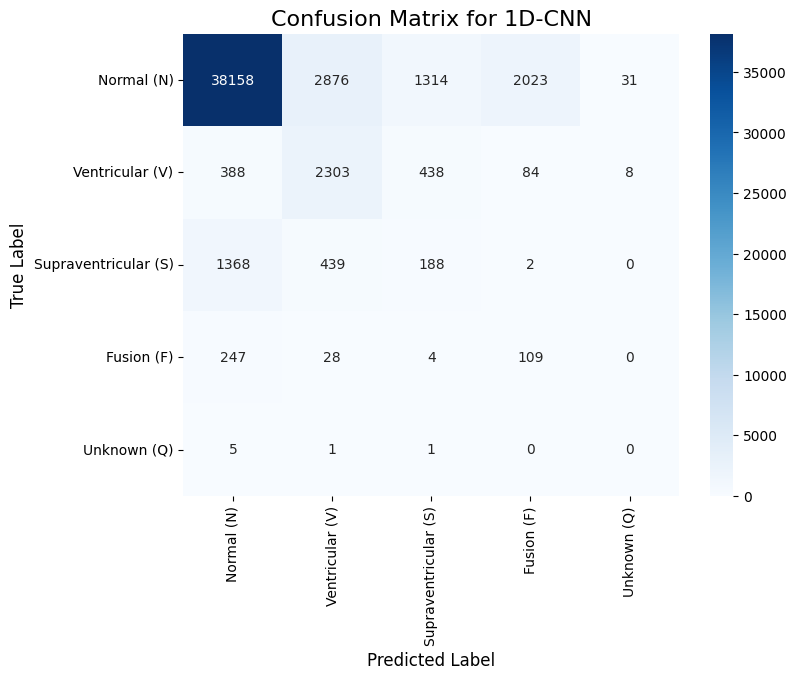



--- REPORT FOR MODEL: RandomForest ---

Classification Report on Test Set:
                      precision    recall  f1-score   support

          Normal (N)       0.95      0.92      0.93     44402
     Ventricular (V)       0.54      0.73      0.62      3221
Supraventricular (S)       0.12      0.06      0.08      1997
          Fusion (F)       0.08      0.28      0.12       388
         Unknown (Q)       0.00      0.00      0.00         7

            accuracy                           0.87     50015
           macro avg       0.34      0.40      0.35     50015
        weighted avg       0.88      0.87      0.87     50015

Confusion Matrix:


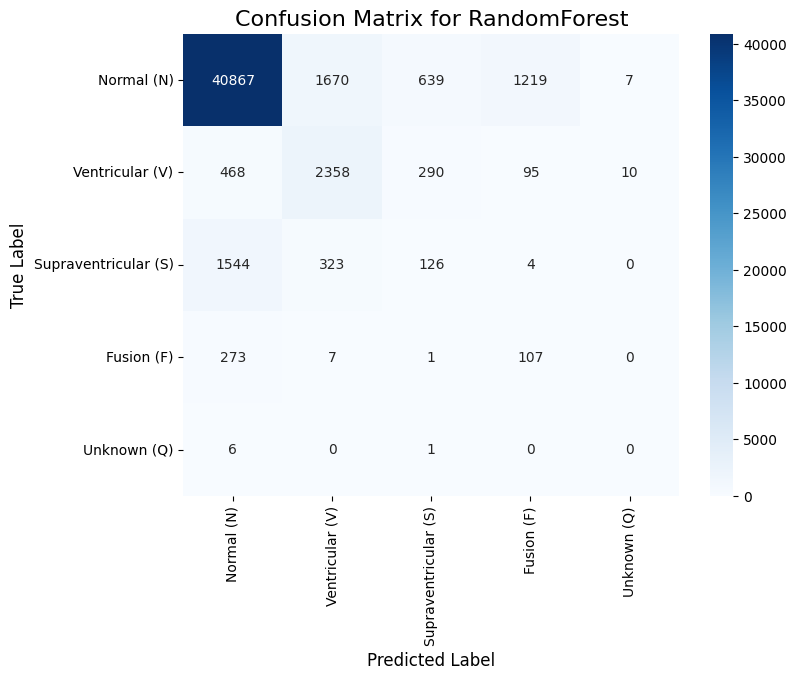



--- REPORT FOR MODEL: MLP ---

Classification Report on Test Set:
                      precision    recall  f1-score   support

          Normal (N)       0.95      0.92      0.93     44402
     Ventricular (V)       0.43      0.67      0.53      3221
Supraventricular (S)       0.16      0.09      0.12      1997
          Fusion (F)       0.07      0.19      0.11       388
         Unknown (Q)       0.00      0.00      0.00         7

            accuracy                           0.86     50015
           macro avg       0.32      0.37      0.34     50015
        weighted avg       0.88      0.86      0.87     50015

Confusion Matrix:


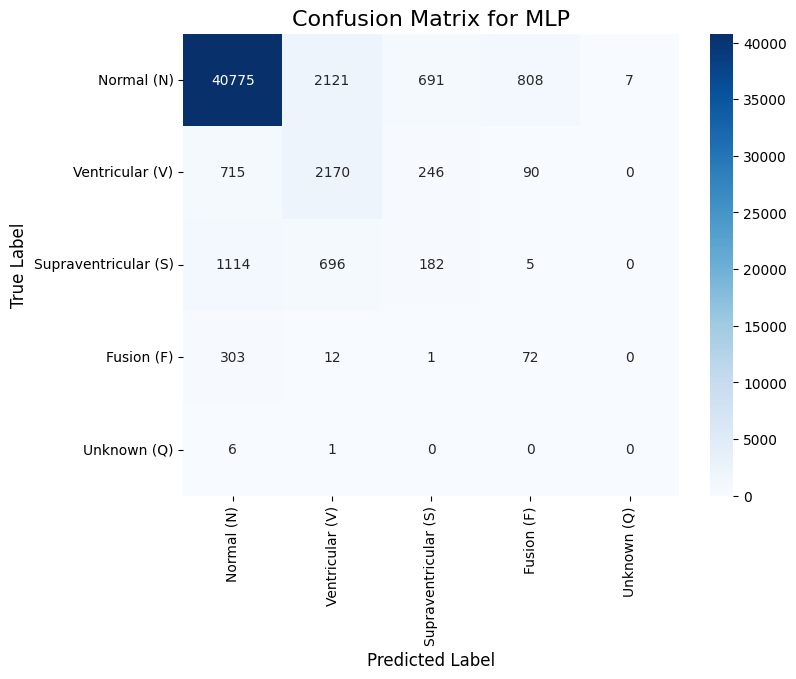

In [11]:
# Training Multiple Models
input_shape_cnn = (X_train_cnn.shape[1], X_train_cnn.shape[2])
input_dim = X_train_mlp.shape[1]

models = {
    "1D-CNN": create_cnn_model_optimized(input_shape_cnn, output_dim),
    "RandomForest": create_rf_model(),
    "MLP": create_mlp_model(input_dim, output_dim)
}

# Dictionary to store the final results
results = {}

# --- TRAINING AND EVALUATING EACH MODEL ---

for name, model in models.items():
    print(f"\n{'='*20} TRAINING MODEL: {name} {'='*20}")

    # 🧠 Training
    if name == "1D-CNN":
        model.fit(
            X_train_cnn, y_train_cnn,
            epochs=150,
            batch_size=100,
            verbose=1,
            validation_data=(X_val_cnn, y_val_cnn) # Using the existing validation set
        )
    elif name == "MLP":
        model.fit(
            X_train_mlp, y_train_mlp,
            epochs=100,
            batch_size=50,
            verbose=1,
            validation_data=(X_val_mlp, y_val_mlp) # Using the existing validation set
        )
    else: # 📊 RandomForest
        model.fit(X_train_rf, y_train_rf)

    # ⚡ Prediction on the Test Set
    print(f"Evaluating model {name}...")
    if name == "MLP":
        y_pred_raw = model.predict(X_test_mlp)
        y_pred = np.argmax(y_pred_raw, axis=1)
    elif name == "1D-CNN":
        y_pred_raw = model.predict(X_test_cnn)
        y_pred = np.argmax(y_pred_raw, axis=1)
    else: # RandomForest
        y_pred = model.predict(X_test_rf)

    # Save prediction results for final evaluation
    results[name] = {'y_pred': y_pred}

# --- PRINT ALL RESULTS SIMULTANEOUSLY ---

class_names = ['Normal (N)', 'Ventricular (V)', 'Supraventricular (S)', 'Fusion (F)', 'Unknown (Q)']

print(f"\n{'='*25} FINAL EVALUATION RESULTS {'='*25}")

for name, result_data in results.items():
    y_pred_test = result_data['y_pred']

    print(f"\n\n--- REPORT FOR MODEL: {name} ---")

    # Standard Classification Report (using y_test_rf which are the original integer labels)
    print("\nClassification Report on Test Set:")
    print(classification_report(y_test_rf, y_pred_test, target_names=class_names, zero_division=0))

    # --- Confusion Matrix Visualization ---
    print("Confusion Matrix:")
    cm = confusion_matrix(y_test_rf, y_pred_test)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f'Confusion Matrix for {name}', fontsize=16)
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.show()

Calculating class weights for the current fold...
Manual Calculation Breakdown:
  Weight for Class 0 (Normal (N)): 45885 / (4 * 41254) = 0.2781
  Weight for Class 1 (Ventricular (V)): 45885 / (4 * 3410) = 3.3640
  Weight for Class 2 (Supraventricular (S)): 45885 / (4 * 849) = 13.5115
  Weight for Class 3 (Fusion (F)): 45885 / (4 * 372) = 30.8367
Fold Weights: {0: 0.27806394531439377, 1: 3.3640029325513194, 2: 13.51148409893993, 3: 30.836693548387096}

==================== CREATING 1D-CNN MODEL ====================


Model: "functional_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_12 (InputLayer)     │ (None, 400, 1)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1_freezed (Conv1D)       │ (None, 398, 64)        │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool1d_1_freezed             │ (None, 199, 64)        │             0 │
│ (MaxPooling1D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2_freezed (Conv1D)       │ (None, 199, 64)        │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool1d_2_freezed             │ (None, 99, 64)         │             0 │
│ (MaxPooling1D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3_freezed (Conv1D)       │ (None, 99, 4)          │           772 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool1d_3_freezed             │ (None, 49, 4)          │             0 │
│ (MaxPooling1D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4_trainable (Conv1D)     │ (None, 49, 100)        │         1,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_layer (Flatten)         │ (None, 4900)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1_trainable (Dense)       │ (None, 256)            │     1,254,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer_trainable (Dense)  │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,270,364 (4.85 MB)

 Trainable params: 1,270,364 (4.85 MB)

 Non-trainable params: 0 (0.00 B)


==================== TRAINING 1D-CNN MODEL ====================
Epoch 1/150


2025-08-27 22:00:36.152903: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_676', 4 bytes spill stores, 4 bytes spill loads

2025-08-27 22:00:36.568088: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_982', 12 bytes spill stores, 12 bytes spill loads



407/408 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4599 - f1_score: 0.5356 - loss: 1.0018 - precision: 0.6810 - recall: 0.1962 - specificity: 0.5021

2025-08-27 22:00:44.109096: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_676', 4 bytes spill stores, 4 bytes spill loads

2025-08-27 22:00:44.315456: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_982', 36 bytes spill stores, 36 bytes spill loads



408/408 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.4603 - f1_score: 0.5361 - loss: 1.0011 - precision: 0.6813 - recall: 0.1968 - specificity: 0.5025

2025-08-27 22:00:49.301987: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_223', 4 bytes spill stores, 4 bytes spill loads



408/408 ━━━━━━━━━━━━━━━━━━━━ 18s 29ms/step - accuracy: 0.6429 - f1_score: 0.7224 - loss: 0.7210 - precision: 0.8061 - recall: 0.4343 - specificity: 0.6780 - val_accuracy: 0.8490 - val_f1_score: 0.8786 - val_loss: 0.5676 - val_precision: 0.8816 - val_recall: 0.7599 - val_specificity: 0.9161
Epoch 2/150
408/408 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.8504 - f1_score: 0.8867 - loss: 0.4107 - precision: 0.8786 - recall: 0.7924 - specificity: 0.9166 - val_accuracy: 0.8749 - val_f1_score: 0.9071 - val_loss: 0.4522 - val_precision: 0.8915 - val_recall: 0.8485 - val_specificity: 0.9456
Epoch 3/150
408/408 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.8903 - f1_score: 0.9162 - loss: 0.3180 - precision: 0.9081 - recall: 0.8636 - specificity: 0.9580 - val_accuracy: 0.9362 - val_f1_score: 0.9445 - val_loss: 0.2743 - val_precision: 0.9473 - val_recall: 0.9215 - val_specificity: 0.9864
Epoch 4/150
408/408 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.9053 - f1_score: 0.9265 - loss: 0.264

2025-08-27 22:11:37.254086: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_91', 4 bytes spill stores, 4 bytes spill loads



1553/1555 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

2025-08-27 22:11:40.728059: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_107', 12 bytes spill stores, 12 bytes spill loads



1555/1555 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step

~~~~~~~~~~~~~~~ REPORT FOR 1D-CNN MODEL ~~~~~~~~~~~~~~~

Classification Report:
                      precision    recall  f1-score   support

          Normal (N)       0.94      0.74      0.83     44241
     Ventricular (V)       0.50      0.85      0.63      3220
Supraventricular (S)       0.03      0.08      0.04      1890
          Fusion (F)       0.01      0.16      0.02       388

            accuracy                           0.71     49739
           macro avg       0.37      0.46      0.38     49739
        weighted avg       0.87      0.71      0.78     49739

Confusion Matrix:


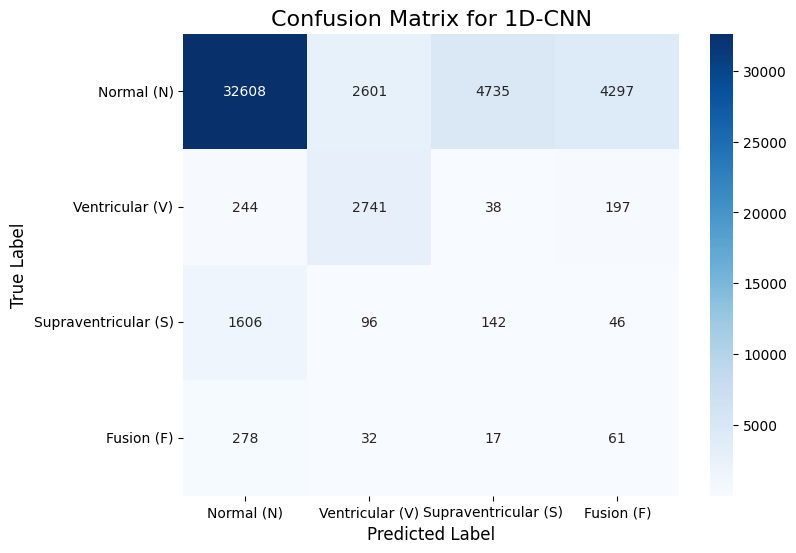


--- Saving model: 1D-CNN ---
✅ Model 1D-CNN has been saved on: ../models/model_1d-cnn_saved.keras


In [11]:
# --- Single-Fold Training --
# Define input and output dimensions for the CNN model
input_shape_cnn = (X_train_cnn.shape[1], X_train_cnn.shape[2])
output_dim = y_train_cnn.shape[1]

# Define the output directory for saving the model
output_dir = '../models'
os.makedirs(output_dir, exist_ok=True)

# --- Manual Class Weights Calculation for the current fold ---
print("Calculating class weights for the current fold...")
n_samples = len(y_train)
class_counts = Counter(y_train)
n_classes = len(class_counts)

manual_weights = {}
print("Manual Calculation Breakdown:")
for i in range(n_classes):
    n_samples_in_class = class_counts.get(i, 0) # Use .get for safety
    weight = n_samples / (n_classes * n_samples_in_class)
    manual_weights[i] = weight
    print(f"  Weight for Class {i} ({class_names[i]}): {n_samples} / ({n_classes} * {n_samples_in_class}) = {weight:.4f}")

class_weights_dict = dict(manual_weights)
print("Fold Weights:", class_weights_dict)

# --- Model Creation ---
print(f"\n{'='*20} CREATING 1D-CNN MODEL {'='*20}")
model = create_cnn_model_optimized(input_shape_cnn, output_dim)
model.summary()

# --- Model Training ---
print(f"\n{'='*20} TRAINING 1D-CNN MODEL {'='*20}")
model.fit(
    X_train_cnn, y_train_cnn,
    epochs=150,
    batch_size=100,
    verbose=1,
    validation_data=(X_val_cnn, y_val_cnn),
    class_weight=class_weights_dict
)

# --- Model Evaluation ---
print(f"\n{'='*20} EVALUATING 1D-CNN MODEL {'='*20}")
# Predict on the test set
y_pred_raw = model.predict(X_test_cnn)
y_pred = np.argmax(y_pred_raw, axis=1)
y_true = y_test_final # Use the final, combined ground truth labels

# --- Final Evaluation Report ---
class_names = ['Normal (N)', 'Ventricular (V)', 'Supraventricular (S)', 'Fusion (F)']
print(f"\n{'~'*15} REPORT FOR 1D-CNN MODEL {'~'*15}")

# --- Classification Report ---
print("\nClassification Report:")
report = classification_report(y_true, y_pred, target_names=class_names, zero_division=0)
print(report)

# --- Confusion Matrix Visualization ---
print("Confusion Matrix:")
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix for 1D-CNN', fontsize=16)
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.show()

# --- Saving the Model ---
print(f"\n--- Saving model: 1D-CNN ---")
model_path = os.path.join(output_dir, "model_1d-cnn_saved.keras")
# Use model.save() for Keras models for better compatibility
model.save(model_path) 
print(f"✅ Model 1D-CNN has been saved on: {model_path}")

In [13]:
# Training Multiple Models
input_shape_cnn = (X_train_cnn.shape[1], X_train_cnn.shape[2])
input_dim = X_train_mlp.shape[1]
output_dim = y_train_mlp.shape[1]

# Saving/exporting models
output_dir = '../models'
os.makedirs(output_dir, exist_ok=True)

# Class Weights
print("--- Calculating Class Weights for Cost-Sensitive Learning ---")
class_weights = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(y_train_fold),
    y=y_train_fold
)
class_weights_dict = dict(enumerate(class_weights))
print("Calculated Weights:", class_weights_dict)

models = {
    "1D-CNN": create_cnn_model_optimized(input_shape_cnn, output_dim),
    "RandomForest": create_rf_model(),
    "MLP": create_mlp_model(input_dim, output_dim)
}

# Dictionary to store the final results
results = {}

# --- TRAINING AND EVALUATING EACH MODEL ---

for name, model in models.items():
    print(f"\n{'='*20} TRAINING MODEL: {name} {'='*20}")

    # 🧠 Training
    if name == "1D-CNN":
        model.fit(
            X_train_cnn, y_train_cnn,
            epochs=150, # Reduced for quick example
            batch_size=100,
            verbose=1, # Set to 0 to keep output clean
            validation_data=(X_val_cnn, y_val_cnn),
            class_weight=class_weights_dict
        )
    elif name == "MLP":
        model.fit(
            X_train_mlp, y_train_mlp,
            epochs=150, # Reduced for quick example
            batch_size=100,
            verbose=1,
            validation_data=(X_val_mlp, y_val_mlp),
            class_weight=class_weights_dict
        )
    else: # 📊 RandomForest
        model.fit(X_train_rf, y_train_rf)

    # ⚡ Prediction on the Test Set
    print(f"Evaluating model {name}...")
    if name in ["MLP", "1D-CNN"]:
        y_pred_raw = model.predict(X_test_mlp if name == "MLP" else X_test_cnn)
        y_pred = np.argmax(y_pred_raw, axis=1)
    else: # RandomForest
        y_pred = model.predict(X_test_rf)

    # Store prediction results and ground truth for final evaluation
    results[name] = {'y_pred': y_pred, 'y_true': y_test_final}

# --- PRINT ALL RESULTS SIMULTANEOUSLY ---
class_names = ['Normal (N)', 'Ventricular (V)', 'Supraventricular (S)', 'Fusion (F)']

print(f"\n{'='*25} FINAL EVALUATION RESULTS {'='*25}")

for name, result_data in results.items():
    y_true = result_data['y_true']
    y_pred = result_data['y_pred']

    print(f"\n\n{'~'*15} REPORT FOR MODEL: {name} {'~'*15}")
    
    # --- Classification Report ---
    print("\nClassification Report:")
    report = classification_report(y_true, y_pred, target_names=class_names, zero_division=0)
    print(report)

    # --- Confusion Matrix Visualization ---
    print("Confusion Matrix:")
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f'Confusion Matrix for {name}', fontsize=16)
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.show()

    # SAVING MODEL AFTER TRAINING
    print(f"--- Saving model: {name} ---")
    if name in ["1D-CNN", "MLP"]:
        # TensorFlow/Keras models
        model_path = os.path.join(output_dir, f"model_{name.lower()}_saved")
        model.export(model_path) # Saving models
        print(f"✅ Model {name} has been saved on: {model_path}")
    else: #RandomForest/other scikit-learn models
        model_path = os.path.join(output_dir, f"model_{name.lower()}.joblib")
        joblib.dump(model, model_path) # Saving models
        print(f"✅ Model {name} has been saved on: {model_path}")

--- Calculating Class Weights for Cost-Sensitive Learning ---
Calculated Weights: {0: np.float64(0.27806108535587676), 1: np.float64(3.365181518151815), 2: np.float64(13.505298013245033), 3: np.float64(30.805135951661633)}

==================== TRAINING MODEL: 1D-CNN ====================


/mnt/c/Users/OSOTNAS/Documents/Kean/Others/KP_Xirka-Darma-Persada/machine-learning/.venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/150


2025-08-27 11:35:48.162458: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2279', 16 bytes spill stores, 16 bytes spill loads

2025-08-27 11:35:48.487933: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2279', 64 bytes spill stores, 64 bytes spill loads

2025-08-27 11:35:48.523692: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2279', 568 bytes spill stores, 568 bytes spill loads

2025-08-27 11:35:48.538194: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2279', 4 bytes spill stores, 4 bytes spill loads

2025-08-27 11:35:48.809707: I external/l

407/408 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - f1_score: 0.6427 - loss: 0.9673 - precision: 0.5466 - recall: 0.3570 - specificity: 0.5486

2025-08-27 11:36:36.404248: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2279', 64 bytes spill stores, 64 bytes spill loads

2025-08-27 11:36:36.540186: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2279', 4 bytes spill stores, 4 bytes spill loads

2025-08-27 11:36:36.600333: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2279', 568 bytes spill stores, 568 bytes spill loads

2025-08-27 11:36:37.064830: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2279_0', 1700 bytes spill stores, 1416 bytes spill loads

2025-08-27 11:36:37.092143: I exte

408/408 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - f1_score: 0.6428 - loss: 0.9669 - precision: 0.5468 - recall: 0.3572 - specificity: 0.5489

2025-08-27 11:36:53.022055: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_264', 4 bytes spill stores, 4 bytes spill loads

2025-08-27 11:36:53.332319: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_264', 16 bytes spill stores, 16 bytes spill loads

2025-08-27 11:36:53.490201: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_264', 568 bytes spill stores, 568 bytes spill loads

2025-08-27 11:36:53.517761: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_264', 116 bytes spill stores, 116 bytes spill loads

2025-08-27 11:36:53.806042: I external/loc

408/408 ━━━━━━━━━━━━━━━━━━━━ 72s 143ms/step - f1_score: 0.6894 - loss: 0.7975 - precision: 0.6038 - recall: 0.4388 - specificity: 0.6404 - val_f1_score: 0.8785 - val_loss: 0.5072 - val_precision: 0.9218 - val_recall: 0.8993 - val_specificity: 0.9741
Epoch 2/150
408/408 ━━━━━━━━━━━━━━━━━━━━ 40s 98ms/step - f1_score: 0.7903 - loss: 0.5618 - precision: 0.7362 - recall: 0.6255 - specificity: 0.7711 - val_f1_score: 0.7772 - val_loss: 0.6624 - val_precision: 0.6895 - val_recall: 0.6073 - val_specificity: 0.8056
Epoch 3/150
408/408 ━━━━━━━━━━━━━━━━━━━━ 40s 98ms/step - f1_score: 0.8430 - loss: 0.4548 - precision: 0.8108 - recall: 0.7318 - specificity: 0.8581 - val_f1_score: 0.6983 - val_loss: 0.8745 - val_precision: 0.5845 - val_recall: 0.5190 - val_specificity: 0.6961
Epoch 4/150
408/408 ━━━━━━━━━━━━━━━━━━━━ 40s 97ms/step - f1_score: 0.8656 - loss: 0.4049 - precision: 0.8375 - recall: 0.7773 - specificity: 0.8922 - val_f1_score: 0.8388 - val_loss: 0.6719 - val_precision: 0.8167 - val_recall: 

KeyboardInterrupt: 

In [ ]:
# --- [Step 4] 10-Fold Cross-Validation Training and Evaluation ---
print("\n" + "="*60)
print("--- [Step 4] Starting 10-Fold Cross-Validation ---")
print("="*60)

n_splits = 10
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
unique_classes = np.unique(y_train)
output_dim = len(unique_classes)
class_names = ['Normal (N)', 'Ventricular (V)', 'Supraventricular (S)', 'Fusion (F)']

results = {
    'RandomForest': {'accuracy': [], 'recall_macro': [], 'f1_macro': [], 'specificity_macro': [], 'y_true': [], 'y_pred': []},
    'MLP': {'accuracy': [], 'recall_macro': [], 'f1_macro': [], 'specificity_macro': [], 'y_true': [], 'y_pred': []},
    '1D-CNN': {'accuracy': [], 'recall_macro': [], 'f1_macro': [], 'specificity_macro': [], 'y_true': [], 'y_pred': []}
}

# Loop through the folds
for fold, (train_index, val_index) in enumerate(skf.split(X_train_features_scaled, y_train)):
    print(f"\n--- FOLD {fold+1}/{n_splits} ---")
    
    # --- Prepare data for this fold ---
    X_train_feat_fold, X_val_feat_fold = X_train_features_scaled[train_index], X_train_features_scaled[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]
    X_train_raw_fold, X_val_raw_fold = X_train_raw[train_index], X_train_raw[val_index]

    # --- Apply SMOTE only to the training part of the fold ---
    print("Applying SMOTE to the training fold...")
    sampler = SMOTE(random_state=42)
    X_train_feat_resampled, y_train_feat_resampled = sampler.fit_resample(X_train_feat_fold, y_train_fold)
    
    # --- RandomForest Training & Evaluation ---
    print("\nTraining RandomForest...")
    rf_model = create_rf_model()
    rf_model.fit(X_train_feat_resampled, y_train_feat_resampled)
    y_pred_rf = rf_model.predict(X_val_feat_fold)
    
    results['RandomForest']['accuracy'].append(accuracy_score(y_val_fold, y_pred_rf))
    results['RandomForest']['recall_macro'].append(recall_score(y_val_fold, y_pred_rf, average='macro', zero_division=0))
    results['RandomForest']['f1_macro'].append(f1_score(y_val_fold, y_pred_rf, average='macro', zero_division=0))
    results['RandomForest']['specificity_macro'].append(calculate_specificity(y_val_fold, y_pred_rf, classes=unique_classes))
    results['RandomForest']['y_true'].extend(y_val_fold)
    results['RandomForest']['y_pred'].extend(y_pred_rf)
    print(f"RandomForest Fold {fold+1} Accuracy: {results['RandomForest']['accuracy'][-1]:.4f}")

    # --- MLP Training & Evaluation ---
    print("\nTraining MLP...")
    y_train_mlp_cat = to_categorical(y_train_feat_resampled, num_classes=output_dim)
    
    mlp_model = create_mlp_model(input_dim=X_train_feat_resampled.shape[1], output_dim=output_dim)
    mlp_model.fit(X_train_feat_resampled, y_train_mlp_cat, epochs=10, batch_size=128, verbose=0)
    
    y_pred_mlp_prob = mlp_model.predict(X_val_feat_fold)
    y_pred_mlp = np.argmax(y_pred_mlp_prob, axis=1)
    
    results['MLP']['accuracy'].append(accuracy_score(y_val_fold, y_pred_mlp))
    results['MLP']['recall_macro'].append(recall_score(y_val_fold, y_pred_mlp, average='macro', zero_division=0))
    results['MLP']['f1_macro'].append(f1_score(y_val_fold, y_pred_mlp, average='macro', zero_division=0))
    results['MLP']['specificity_macro'].append(calculate_specificity(y_val_fold, y_pred_mlp, classes=unique_classes))
    results['MLP']['y_true'].extend(y_val_fold)
    results['MLP']['y_pred'].extend(y_pred_mlp)
    print(f"MLP Fold {fold+1} Accuracy: {results['MLP']['accuracy'][-1]:.4f}")

    # --- 1D-CNN Training & Evaluation ---
    print("\nTraining 1D-CNN...")
    y_train_cnn_cat = to_categorical(y_train_fold, num_classes=output_dim)

    cnn_model = create_cnn_model_optimized(input_shape=(WINDOW_SIZE, 2), output_dim=output_dim)
    cnn_model.fit(X_train_raw_fold, y_train_cnn_cat, epochs=10, batch_size=128, verbose=0)

    y_pred_cnn_prob = cnn_model.predict(X_val_raw_fold)
    y_pred_cnn = np.argmax(y_pred_cnn_prob, axis=1)

    results['1D-CNN']['accuracy'].append(accuracy_score(y_val_fold, y_pred_cnn))
    results['1D-CNN']['recall_macro'].append(recall_score(y_val_fold, y_pred_cnn, average='macro', zero_division=0))
    results['1D-CNN']['f1_macro'].append(f1_score(y_val_fold, y_pred_cnn, average='macro', zero_division=0))
    results['1D-CNN']['specificity_macro'].append(calculate_specificity(y_val_fold, y_pred_cnn, classes=unique_classes))
    results['1D-CNN']['y_true'].extend(y_val_fold)
    results['1D-CNN']['y_pred'].extend(y_pred_cnn)
    print(f"1D-CNN Fold {fold+1} Accuracy: {results['1D-CNN']['accuracy'][-1]:.4f}")

# --- [Step 5] Final Results Summary ---
print("\n" + "="*60)
print("--- CROSS-VALIDATION SUMMARY ---")
print("="*60)

for model_name, model_results in results.items():
    print(f"\n--- {model_name} ---")
    for metric in ['accuracy', 'recall_macro', 'f1_macro', 'specificity_macro']:
        avg_metric = np.mean(model_results[metric])
        std_metric = np.std(model_results[metric])
        print(f"Average {metric.replace('_', ' ').title()}: {avg_metric:.4f} (+/- {std_metric:.4f})")
    
    print("\nAggregated Classification Report:")
    aggregated_report = classification_report(
        model_results['y_true'], 
        model_results['y_pred'], 
        target_names=class_names,
        zero_division=0
    )
    print(aggregated_report)

    print("Aggregated Confusion Matrix:")
    cm = confusion_matrix(model_results['y_true'], model_results['y_pred'], labels=unique_classes)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f'{model_name} - Aggregated Confusion Matrix')
    plt.show()


--- [Step 4] Starting 10-Fold Cross-Validation ---

--- FOLD 1/10 ---
Applying SMOTE to the training fold...

Training RandomForest...
RandomForest Fold 1 Accuracy: 0.9833

Training MLP...


/mnt/c/Users/OSOTNAS/Documents/Kean/Others/KP_Xirka-Darma-Persada/machine-learning/.venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1756115328.435588     422 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3620 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 6GB Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6
I0000 00:00:1756115331.431610     646 service.cc:152] XLA service 0x7df7b4017490 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1756115331.431648     646 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 6GB Laptop GPU, Compute Capability 8.6
2025-08-25 16:48:51.558219

150/160 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

2025-08-25 16:49:33.319848: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_23', 12 bytes spill stores, 12 bytes spill loads

2025-08-25 16:49:33.472477: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_16', 64 bytes spill stores, 64 bytes spill loads



160/160 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step
MLP Fold 1 Accuracy: 0.9818

Training 1D-CNN...


2025-08-25 16:49:42.897431: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2277', 76 bytes spill stores, 76 bytes spill loads

2025-08-25 16:49:42.943944: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2277', 568 bytes spill stores, 568 bytes spill loads

2025-08-25 16:49:43.449272: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2277', 900 bytes spill stores, 900 bytes spill loads

2025-08-25 16:49:43.663719: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2277', 120 bytes spill stores, 120 bytes spill loads

2025-08-25 16:49:43.817209: I exte

155/160 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step

2025-08-25 16:56:20.251061: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_186', 40 bytes spill stores, 40 bytes spill loads

2025-08-25 16:56:20.271772: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_186', 264 bytes spill stores, 264 bytes spill loads

2025-08-25 16:56:20.293048: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_186', 40 bytes spill stores, 40 bytes spill loads



160/160 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step
1D-CNN Fold 1 Accuracy: 0.9880

--- FOLD 2/10 ---
Applying SMOTE to the training fold...

Training RandomForest...
RandomForest Fold 2 Accuracy: 0.9837

Training MLP...


/mnt/c/Users/OSOTNAS/Documents/Kean/Others/KP_Xirka-Darma-Persada/machine-learning/.venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
MLP Fold 2 Accuracy: 0.9808

Training 1D-CNN...
160/160 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step
1D-CNN Fold 2 Accuracy: 0.9857

--- FOLD 3/10 ---
Applying SMOTE to the training fold...

Training RandomForest...
RandomForest Fold 3 Accuracy: 0.9857

Training MLP...


/mnt/c/Users/OSOTNAS/Documents/Kean/Others/KP_Xirka-Darma-Persada/machine-learning/.venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
MLP Fold 3 Accuracy: 0.9847

Training 1D-CNN...
160/160 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step
1D-CNN Fold 3 Accuracy: 0.9865

--- FOLD 4/10 ---
Applying SMOTE to the training fold...

Training RandomForest...
RandomForest Fold 4 Accuracy: 0.9839

Training MLP...


/mnt/c/Users/OSOTNAS/Documents/Kean/Others/KP_Xirka-Darma-Persada/machine-learning/.venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


149/160 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

2025-08-25 17:13:43.905888: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_16', 64 bytes spill stores, 64 bytes spill loads

2025-08-25 17:13:44.200070: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_23', 12 bytes spill stores, 12 bytes spill loads



160/160 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step
MLP Fold 4 Accuracy: 0.9820

Training 1D-CNN...


2025-08-25 17:14:37.380657: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2277_0', 516 bytes spill stores, 516 bytes spill loads

2025-08-25 17:14:37.412080: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2277', 40 bytes spill stores, 40 bytes spill loads

2025-08-25 17:14:37.421343: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2277', 564 bytes spill stores, 564 bytes spill loads

2025-08-25 17:14:37.487208: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2277', 40 bytes spill stores, 40 bytes spill loads

2025-08-25 17:14:37.938112: I exte

157/160 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step

2025-08-25 17:20:36.561370: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_186', 264 bytes spill stores, 264 bytes spill loads

2025-08-25 17:20:36.624351: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_186', 40 bytes spill stores, 40 bytes spill loads

2025-08-25 17:20:36.802634: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_186', 40 bytes spill stores, 40 bytes spill loads



160/160 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step
1D-CNN Fold 4 Accuracy: 0.9839

--- FOLD 5/10 ---
Applying SMOTE to the training fold...

Training RandomForest...
RandomForest Fold 5 Accuracy: 0.9825

Training MLP...


/mnt/c/Users/OSOTNAS/Documents/Kean/Others/KP_Xirka-Darma-Persada/machine-learning/.venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
MLP Fold 5 Accuracy: 0.9792

Training 1D-CNN...
160/160 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step
1D-CNN Fold 5 Accuracy: 0.9906

--- FOLD 6/10 ---
Applying SMOTE to the training fold...

Training RandomForest...
RandomForest Fold 6 Accuracy: 0.9835

Training MLP...


/mnt/c/Users/OSOTNAS/Documents/Kean/Others/KP_Xirka-Darma-Persada/machine-learning/.venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
MLP Fold 6 Accuracy: 0.9814

Training 1D-CNN...
160/160 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step
1D-CNN Fold 6 Accuracy: 0.9904

--- FOLD 7/10 ---
Applying SMOTE to the training fold...

Training RandomForest...
RandomForest Fold 7 Accuracy: 0.9831

Training MLP...


/mnt/c/Users/OSOTNAS/Documents/Kean/Others/KP_Xirka-Darma-Persada/machine-learning/.venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
MLP Fold 7 Accuracy: 0.9823

Training 1D-CNN...
160/160 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step
1D-CNN Fold 7 Accuracy: 0.9890

--- FOLD 8/10 ---
Applying SMOTE to the training fold...

Training RandomForest...
RandomForest Fold 8 Accuracy: 0.9845

Training MLP...


/mnt/c/Users/OSOTNAS/Documents/Kean/Others/KP_Xirka-Darma-Persada/machine-learning/.venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
MLP Fold 8 Accuracy: 0.9816

Training 1D-CNN...


## **SAVING MACHINE LEARNING MODELS AFTER TRAINING**

In [ ]:
# Cukup panggil model.save() dan berikan nama folder tujuan.
CNN_folder = '../models/1D-CNN'
model_mlp.save(nama_folder_model)

print(f"\nModel MLP telah disimpan dalam folder: '{nama_folder_model}'")

# Gunakan joblib.dump() untuk menyimpan model ke dalam satu file
nama_file_model = 'model_brf.joblib'
joblib.dump(model_brf, nama_file_model)

print(f"\nModel telah disimpan sebagai file: '{nama_file_model}'")